In [17]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import matplotlib.figure as figure
from matplotlib import rcParams
from sklearn.decomposition import PCA  # scikit-learn の中の PCA を実行するためのライブラリのインポート
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_predict, RandomizedSearchCV, GridSearchCV
from sklearn.inspection import permutation_importance
import seaborn as sns
from scipy.stats import randint, uniform # 整数や連続値の分布用
from scipy.spatial.distance import cdist
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler # StandardScalerをインポート

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor

In [13]:
def pred_plot(target,y_train,estimated_y_train,y_test,estimated_y_test):
   # テストデータの実測値 vs. 推定値のプロット
    power = 4 #小数点以下２位まで保存
    train_r2 = int(metrics.r2_score(y_train, estimated_y_train)*10**power)/(10**power)
    train_RMSE = int(metrics.mean_squared_error(y_train, estimated_y_train) ** 0.5*10**(power))/(10**power)
    train_MAE = int(metrics.mean_absolute_error(y_train, estimated_y_train)*10**power)/(10**power)
    test_r2 = int(metrics.r2_score(y_test, estimated_y_test)*10**power)/(10**power)
    test_RMSE = int(metrics.mean_squared_error(y_test, estimated_y_test) ** 0.5*10**(power))/(10**power)
    test_MAE = int(metrics.mean_absolute_error(y_test, estimated_y_test)*10**power)/(10**power)

    plt.rcParams['font.family'] = 'Hiragino Maru Gothic Pro'
    fig,axes =plt.subplots(1,2,figsize=(12,6))

    axes[0].set_aspect('equal',adjustable='box')  # 図の形を正方形に
    axes[0].scatter(y_train, estimated_y_train.iloc[:, 0], c='blue')  # 実測値 vs. 推定値プロット
    y_max = max(y_test.iloc[:, 0].max(), estimated_y_test['pred_y'].max())  # 実測値の最大値と、推定値の最大値の中で、より大きい値を取得
    y_min = min(y_test.iloc[:, 0].min(), estimated_y_test['pred_y'].min())  # 実測値の最小値と、推定値の最小値の中で、より小さい値を取得
    axes[0].plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
            [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')  # 取得した最小値-5%から最大値+5%まで、対角線を作成
    axes[0].set_ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))  # y 軸の範囲の設定
    axes[0].set_xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))  # x 軸の範囲の設定
    axes[0].set_xlabel(f'{target} (実測値)') # x 軸の名前
    axes[0].set_ylabel(f'{target} (予測値)')  # y 軸の名前
    axes[0].set_title(f'訓練データの実測値 vs 推定値\n目的変数:{target}',fontsize=14)
    axes[0].text(0.2, 0.9,f'$r^2$:{train_r2}\nRMSE:{train_RMSE}\nMAE:{train_MAE}',transform=axes[0].transAxes, ha='center', va='top',fontsize=12)

    axes[1].set_aspect('equal',adjustable='box')  # 図の形を正方形に
    axes[1].scatter(y_test, estimated_y_test.iloc[:, 0], c='blue')  # 実測値 vs. 推定値プロット
    axes[1].plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
            [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')  # 取得した最小値-5%から最大値+5%まで、対角線を作成
    axes[1].set_ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))  # y 軸の範囲の設定
    axes[1].set_xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))  # x 軸の範囲の設定
    axes[1].set_xlabel(f'{target} (実測値)') # x 軸の名前
    axes[1].set_ylabel(f'{target} (予測値)')  # y 軸の名前
    axes[1].set_title(f'テストデータの実測値 vs 推定値\n目的変数:{target}',fontsize=14)
    axes[1].text(0.2, 0.9,f'$r^2$:{test_r2}\nRMSE:{test_RMSE}\nMAE:{test_MAE}',transform=axes[1].transAxes, ha='center', va='top',fontsize=12)
    plt.show()  # 以上の設定で描画

In [21]:
df = pd.read_csv('PBL_maccs.csv')
df = df.drop(columns=['Unnamed: 0','Unnamed: 0.1','Names','Classes'])
target = 'Inhibition'
y = df[target] #目的変数
y = y.to_frame()
x = df.drop(columns=[target]) #説明変数
print(x.head)
y_std = np.std(y.values, ddof=1)
y_ave = np.mean(y.values)
print(f'目的変数:{target},説明変数:{x.shape[1]},データ数:{x.shape[0]},\n平均値：{y_ave:.3f},標本標準偏差:{y_std:.3f}')

<bound method NDFrame.head of       MACCS_0  MACCS_1  MACCS_2  MACCS_3  MACCS_4  MACCS_5  MACCS_6  MACCS_7  \
0           0        0        0        0        0        0        0        0   
1           0        0        0        0        0        0        0        0   
2           0        0        0        0        0        0        0        0   
3           0        0        0        0        0        0        0        0   
4           0        0        0        0        0        0        0        0   
...       ...      ...      ...      ...      ...      ...      ...      ...   
2284        0        0        0        0        0        0        0        0   
2285        0        0        0        0        0        0        0        0   
2286        0        0        0        0        0        0        0        0   
2287        0        0        0        0        0        0        0        0   
2288        0        0        0        0        0        0        0        0   

      MAC

In [22]:
#オートスケーリング
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True,random_state=42)
x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

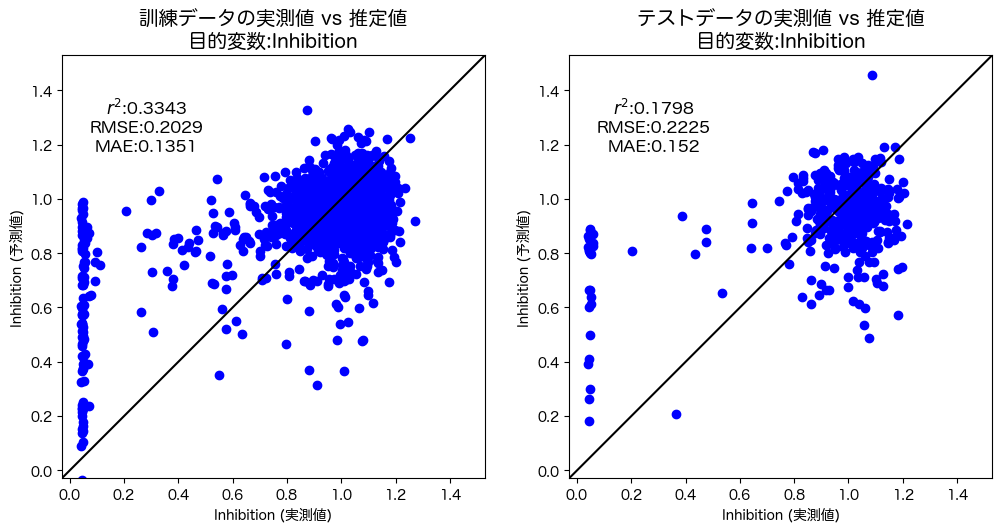

In [23]:
#線形回帰
model = LinearRegression()
model.fit(x_train_scaled,y_train_scaled)
pred_y_train_scaled = model.predict(x_train_scaled)  # y の推定
pred_y_train = y_scaler.inverse_transform(pred_y_train_scaled) #逆変換
pred_y_train = pd.DataFrame(pred_y_train, index=x_train.index, columns=['pred_y'])

# テストデータの推定
pred_y_test_scaled = model.predict(x_test_scaled)  # y の推定
pred_y_test = y_scaler.inverse_transform(pred_y_test_scaled)
pred_y_test = pd.DataFrame(pred_y_test, index=x_test.index, columns=['pred_y'])

pred_plot(target,y_train,pred_y_train,y_test,pred_y_test)

/Users/h-yokuto/Developer/DSPBL/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


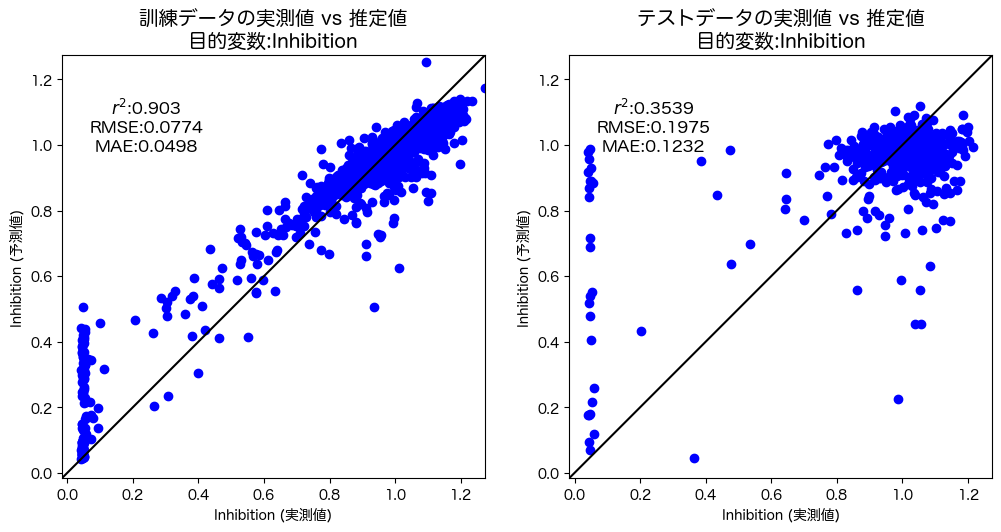

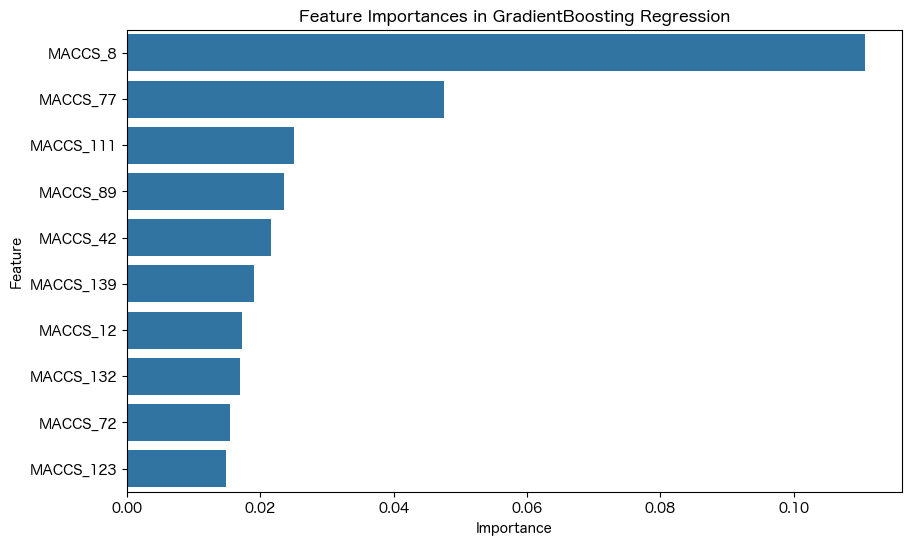

In [26]:
#ランダムフォレスト
model = model = RandomForestRegressor(
    n_estimators=100)
model.fit(x_train_scaled,y_train_scaled)
pred_y_train_scaled = model.predict(x_train_scaled)  # y の推定
pred_y_train = y_scaler.inverse_transform(pred_y_train_scaled.reshape(-1, 1))
pred_y_train = pd.DataFrame(pred_y_train, index=x_train.index, columns=['pred_y'])
 #逆変換

# テストデータの推定
pred_y_test_scaled = model.predict(x_test_scaled)  # y の推定
pred_y_test = y_scaler.inverse_transform(pred_y_test_scaled.reshape(-1,1))
pred_y_test = pd.DataFrame(pred_y_test, index=x_test.index, columns=['pred_y'])

pred_plot(target,y_train,pred_y_train,y_test,pred_y_test)

# 特徴量の重要度を取得
importances = model.feature_importances_
feature_names = x.columns

# 重要度をデータフレームにまとめる
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 可視化
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Feature Importances in GradientBoosting Regression')
plt.show()


/Users/h-yokuto/Developer/DSPBL/.venv/lib/python3.13/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Optimal number of estimators after early stopping: 1342


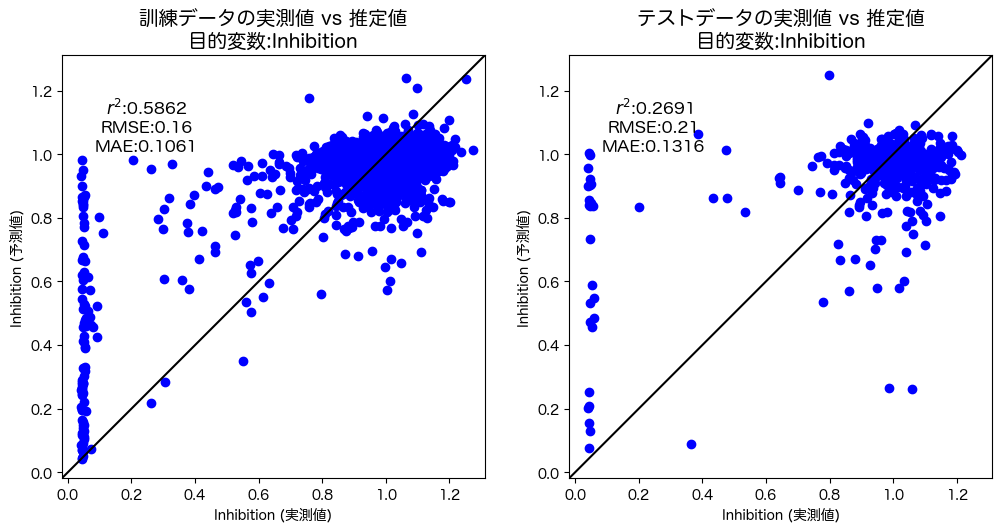

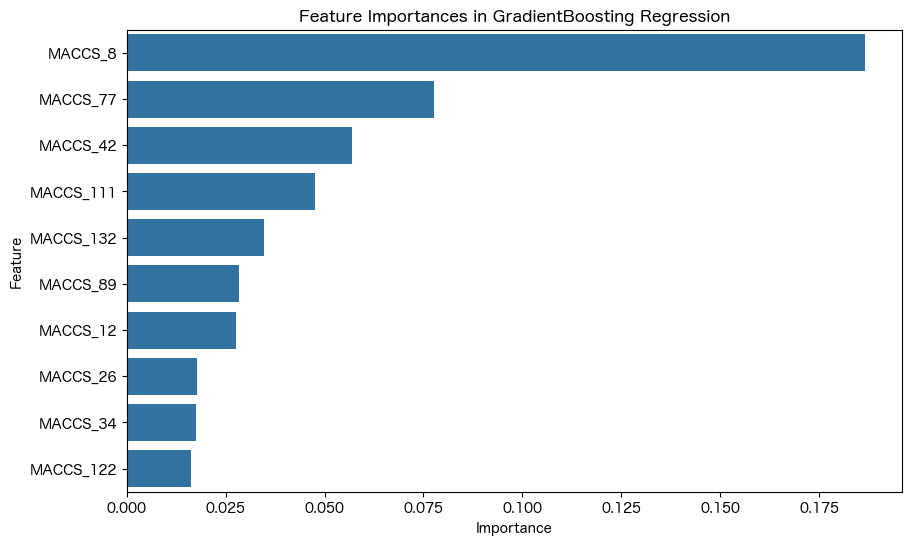

In [25]:
#購買ブースト
# GBR　勾配ブースティング木（決定木を継承していく）
model = GradientBoostingRegressor(n_estimators=2000,learning_rate=0.01,max_depth=3,random_state=42,n_iter_no_change=50,validation_fraction=0.1,tol=0.0001)
model.fit(x_train_scaled,y_train_scaled)
pred_y_train_scaled = model.predict(x_train_scaled)  # y の推定
pred_y_train = y_scaler.inverse_transform(pred_y_train_scaled.reshape(-1, 1))
pred_y_train = pd.DataFrame(pred_y_train, index=x_train.index, columns=['pred_y'])
 #逆変換

# テストデータの推定
pred_y_test_scaled = model.predict(x_test_scaled)  # y の推定
pred_y_test = y_scaler.inverse_transform(pred_y_test_scaled.reshape(-1,1))
pred_y_test = pd.DataFrame(pred_y_test, index=x_test.index, columns=['pred_y'])
print(f"Optimal number of estimators after early stopping: {model.n_estimators_}")

pred_plot(target,y_train,pred_y_train,y_test,pred_y_test)

# 特徴量の重要度を取得
importances = model.feature_importances_
feature_names = x.columns

# 重要度をデータフレームにまとめる
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 可視化
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Feature Importances in GradientBoosting Regression')
plt.show()